# Compute Average Distance Between Real Location and Perturbated One

In [4]:
import os
import pandas as pd
from sqlalchemy import create_engine
import dotenv
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

Connect to DB if there's not a saved CSV.

In [5]:
CSV_NAME = os.path.join('csvs', f'average_distances.csv')
df = None
if os.path.exists(CSV_NAME):
    df = pd.read_csv(CSV_NAME, index_col=0)
else:
    dotenv.load_dotenv('.env')
    engine = create_engine('postgresql://{0}:{1}@{2}/{3}'.format(
        os.environ.get("TYPEORM_USERNAME"),
        os.environ.get("TYPEORM_PASSWORD"),
        os.environ.get("TYPEORM_HOST"),
        os.environ.get("TYPEORM_DATABASE")), echo=False)

Compute and run the query (takes about 35 seconds).

Get real positions, perturbated only, dummy only and perturbated&dummy samples.

For each table, compute the distance between real and fake position based on timestamp and, at the end, compute the average between distances per timestamp.

In [6]:
if df is None:
    Session = sessionmaker(bind=engine)
    session = Session()

    perDecimals = [1, 2, 3, 4, 5]
    dumUpRadMin = [500, 1000, 1500, 2000, 3000]
    dumUpRadStep = [250, 500, 750, 1000, 2000]

    def create_query(table_prefix: str, r_min='-1', r_step='-1', p_dec='-1'):
        return f'''SELECT
                '{r_min!='-1'}' AS "dummyLocation"
                , '{p_dec!='-1'}' as "gpsPerturbated"
                , '{r_min}' as "dumRadMin"
                , '{r_step}' as "dumRadStep"
                , '{p_dec}' as "pertDec"
                , AVG(ST_Distance(p.location, r.location)) / 1000 as avg
            FROM
                project.{table_prefix}_noise p
                , project.real_noise r
            WHERE r.id = p.real_id
        '''

    def replace(num): return str(num).replace('.', '')

    pert_queries = [create_query(f'perturbated{dec}', p_dec=dec) for dec in perDecimals]
    dummy_queries = [create_query(f"dummy{replace(min)}_{replace(step)}", r_min=min, r_step=step)
                     for min, step in product(dumUpRadMin, dumUpRadStep)]
    dummy_pert_queries = [
        create_query(
            f"dummy_pert{replace(min)}_{replace(step)}_{dec}", r_min=min, r_step=step, p_dec=dec)
        for min, step, dec in product(dumUpRadMin, dumUpRadStep, perDecimals)]

    query = '\r\nUNION ALL\r\n'.join([*pert_queries, *dummy_queries, *dummy_pert_queries])
    # print(query)
    res = session.execute(text(query))
    session.close()

Insert query result in dataframe, replace '-1' with 'NaN' and boolean strings in actual booleans.

Lastly, save the dataframe in CSV and show it.

In [7]:
if df is None:
  df = pd.DataFrame(res.fetchall(), columns=res.keys())
df = df.replace({'dumRadMin': -1, 'dumRadStep': -1, 'pertDec': -1}, np.NaN)
# Pandas does not recognize 'True' and 'False' as booleans
df = df.replace({'True': True, 'False': False})

if not os.path.exists('csvs'):
    os.makedirs('csvs')

df.to_csv(CSV_NAME)
df.sort_values(['dummyLocation', 'gpsPerturbated', 'dumRadMin', 'dumRadStep', 'pertDec'])

,dummyLocation,gpsPerturbated,dumRadMin,dumRadStep,pertDec,avg
0,False,True,NaN,NaN,1.0,8.534379
1,False,True,NaN,NaN,2.0,1.085424
4,False,True,NaN,NaN,3.0,0.118577
3,False,True,NaN,NaN,4.0,0.011516
2,False,True,NaN,NaN,5.0,0.001225
...,...,...,...,...,...,...
96,True,True,3000.0,2000.0,1.0,10.879087
131,True,True,3000.0,2000.0,2.0,4.107441
9,True,True,3000.0,2000.0,3.0,4.003107
20,True,True,3000.0,2000.0,4.0,4.002529


Plot distances based on configuration.

\begin{tabular}{rrrr}
\toprule
 dumRadMin &  dumRadStep &  pertDec &       avg \\
\midrule
     500.0 &       250.0 &      5.0 &  0.624661 \\
     500.0 &       250.0 &      4.0 &  0.624871 \\
     500.0 &       250.0 &      3.0 &  0.631110 \\
     500.0 &       500.0 &      4.0 &  0.749158 \\
     500.0 &       500.0 &      5.0 &  0.749492 \\
     500.0 &       500.0 &      3.0 &  0.755550 \\
     500.0 &       750.0 &      4.0 &  0.874770 \\
     500.0 &       750.0 &      5.0 &  0.874807 \\
     500.0 &       750.0 &      3.0 &  0.879243 \\
     500.0 &      1000.0 &      5.0 &  0.999605 \\
     500.0 &      1000.0 &      4.0 &  1.000357 \\
     500.0 &      1000.0 &      3.0 &  1.004260 \\
    1000.0 &       250.0 &      4.0 &  1.124602 \\
    1000.0 &       250.0 &      5.0 &  1.124925 \\
    1000.0 &       250.0 &      3.0 &  1.128122 \\
    1000.0 &       500.0 &      4.0 &  1.250059 \\
    1000.0 &       500.0 &      5.0 &  1.250339 \\
    1000.0 &       500.0 &      3.0 &  1.2

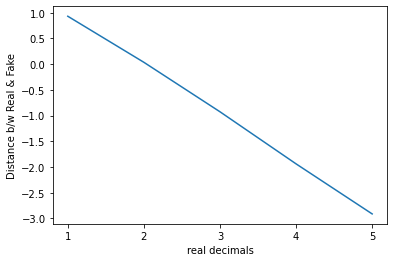

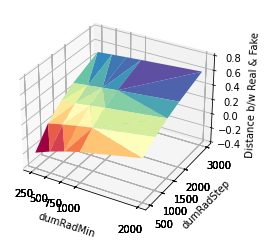

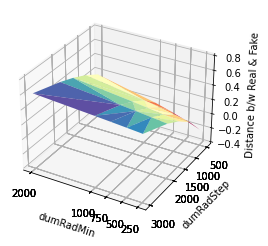

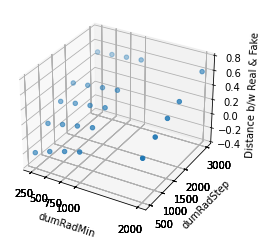

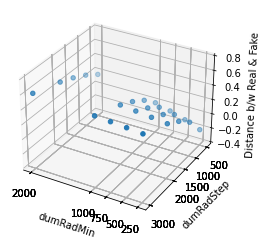

In [8]:
%matplotlib inline

pertOnly = df[(df['gpsPerturbated'] == True) & (df['dummyLocation'] == False)][['pertDec', 'avg']].sort_values('pertDec')
dummyOnly = df[(df['gpsPerturbated'] == False) & (df['dummyLocation'] == True)][['dumRadMin', 'dumRadStep', 'avg']].sort_values(['dumRadMin', 'dumRadStep'])

plt.plot(pertOnly['pertDec'], np.log10(pertOnly['avg'], ))
plt.xticks(pertOnly['pertDec'])
plt.xlabel('real decimals')
plt.ylabel('Distance b/w Real & Fake')
plt.savefig('./privacy_gps.png', dpi=300)

def create_tri_plot():
    fig = plt.figure()
    tri = fig.add_subplot(111, projection='3d')
    tri.plot_trisurf(
        dummyOnly['dumRadStep'],
        dummyOnly['dumRadMin'],
        np.log10(dummyOnly['avg']),
        cmap=plt.cm.Spectral,
        edgecolor='grey',
        linewidth=0.001, antialiased=True)
    tri.set_xticks(dummyOnly['dumRadStep'])
    tri.set_yticks(dummyOnly['dumRadMin'])
    tri.set_zticks(np.arange(-0.4, 0.9, 0.2))
    tri.set_ylabel('dumRadStep')
    tri.set_xlabel('dumRadMin')
    tri.set_zlabel('Distance b/w Real & Fake')
    return tri

def create_scatter_plot(tri):
    fig = plt.figure()
    sca = fig.add_subplot(111, projection='3d')
    sca.scatter(
        dummyOnly['dumRadStep'],
        dummyOnly['dumRadMin'],
        np.log10(dummyOnly['avg']),
        cmap=plt.get_cmap('cool'),)
    sca.set_xticks(tri.get_xticks())
    sca.set_yticks(tri.get_yticks())
    sca.set_zticks(tri.get_zticks())
    sca.set_ylabel('dumRadStep')
    sca.set_xlabel('dumRadMin')
    sca.set_zlabel('Distance b/w Real & Fake')
    return sca

tri_front = create_tri_plot()
plt.savefig('./privacy_dumm_tri_front.png', dpi=300)

tri_back = create_tri_plot()
tri_back.view_init(tri_front.elev, tri_front.azim + 180)
plt.savefig('./privacy_dumm_tri_back.png', dpi=300)

sca_front = create_scatter_plot(tri_front)
plt.savefig('./privacy_dumm_sca_front.png', dpi=300)

sca1 = create_scatter_plot(tri_back)
sca1.view_init(sca_front.elev, sca_front.azim+180)
plt.savefig('./privacy_dumm_sca_back.png', dpi=300)

# pd.set_option("max_row", 1000)
# pd.reset_option('max_row')
print(df[(df['gpsPerturbated'] == True) & (df['dummyLocation'] == True)][['dumRadMin','dumRadStep','pertDec','avg']].sort_values('avg').to_latex(index=False))


Min and Max privacy values

In [9]:
min_max_df = df[df['avg'] == df['avg'].max()].append(df[df['avg'] == df['avg'].min()],ignore_index=True).iloc[:,2:]
min_max_df.index = ['Max', 'Min']
print(min_max_df.to_latex())
min_max_df

\begin{tabular}{lrrrr}
\toprule
{} &  dumRadMin &  dumRadStep &  pertDec &        avg \\
\midrule
Max &     3000.0 &      2000.0 &      1.0 &  10.879087 \\
Min &        NaN &         NaN &      5.0 &   0.001225 \\
\bottomrule
\end{tabular}



,dumRadMin,dumRadStep,pertDec,avg
Max,3000.0,2000.0,1.0,10.879087
Min,NaN,NaN,5.0,0.001225
